In [1]:
import pandas as pd
import seaborn as sns
from  scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, cross_validate

from data_dicts import drop_cols
from data_prep import county_info_2016, county_info_2018, results_info, create_targets
from model_prep import lin_mod_func, run_model, make_predictions, combine_predictions
from visualizations import display_results

## Data

The demographic information was obtained from the U.S. Cencus website. The 5 year study was used in order to obtain the most accurate information for smaller countues. The results data was obtained from the MIT Election Data and Science Lab.

Note: Due to issues with demographic info for Alaska, the state of Alaska is not incorporated into our analysis. These issues will be addressed at a later time.

In [2]:
features_2016 = county_info_2016()
features_2018 = county_info_2018()
results_2016 = results_info(2016)

In [3]:
df = pd.merge(features_2016, results_2016, on='County')
df = df.drop(columns = 'State_y')
df = df.rename(columns={'State_x': 'State'})
df = create_targets(df)

# EDA
The features selected break down into fice categories: education, income, sex, age, and race. 

In [4]:
selected_features = ['Median age',
                     'Sex ratio (males per 100 females)',
                     'Households Median income',
                     'Percent Graduate or professional degree',
                     'Percent Black or African American']

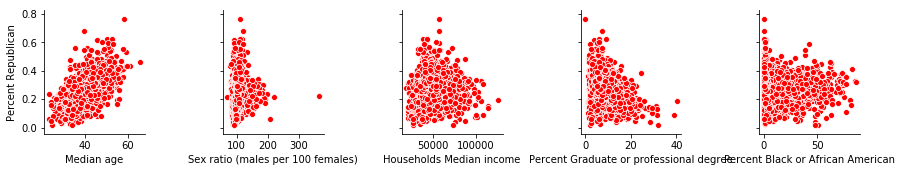

In [5]:
sns.pairplot(df, x_vars=selected_features, y_vars='Percent Republican', plot_kws={'color': 'red'});

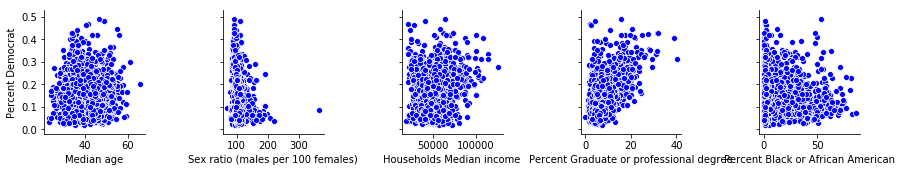

In [6]:
sns.pairplot(df, x_vars=selected_features, y_vars='Percent Democrat', plot_kws={'color': 'blue'});

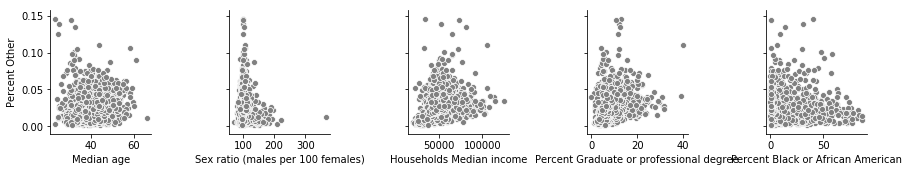

In [7]:
sns.pairplot(df, x_vars=selected_features, y_vars='Percent Other', plot_kws={'color': 'gray'});

In [8]:
#df.iloc[df["Sex ratio (males per 100 females)"].idxmax()]
#df["Sex ratio (males per 100 females)"].max()

In [9]:
#df[df['County'] == 'Fulton County, Georgia, 2016']

In [10]:
#df[df['County'] == 'Kent County, Michigan, 2016']["Percent White"]

In [11]:
#df[df['County'] == 'Allegan County, Michigan, 2016']["Percent White"]

In [12]:
#df[df['County'] == 'Jerome County, Idaho, 2016']["Percent White"]

In [13]:
#df[df['State'] == 'Idaho']['County'].tolist()

## Methodology

The chosen target is the percentage of people who vote for a political party in each county. Republican, Democrat, and Other were chosen as our political parties. Once the percentage of votes obtained is determined, the result is then multiplied by the total population of the county in order to determine the total number of votes each party receives in each county. For maximum interpretability, a linear regression model was used.

In [14]:
y_R = df['Percent Republican']
y_D = df['Percent Democrat']
y_O = df['Percent Other']

X = df.drop(columns=drop_cols)

In [15]:
# Train Test Split for each party
X_train, X_test, y_train_R, y_test_R = train_test_split(X, y_R, random_state=2020)
X_train, X_test, y_train_D, y_test_D = train_test_split(X, y_D, random_state=2020)
X_train, X_test, y_train_O, y_test_O = train_test_split(X, y_O, random_state=2020)

In [16]:
R_model = lin_mod_func(X_train, X_test, y_train_R, y_test_R)

Training R^2 : 0.505233671463541
Training Root Mean Square Error 0.05832121368552937
----------------
Testing R^2 : 0.4609845597220344
Testing Root Mean Square Error 0.06285224572172546


In [17]:
D_model = lin_mod_func(X_train, X_test, y_train_D, y_test_D)

Training R^2 : 0.41387230156907784
Training Root Mean Square Error 0.05538518011664307
----------------
Testing R^2 : 0.40208998428371323
Testing Root Mean Square Error 0.057865803937132004


In [18]:
O_model = lin_mod_func(X_train, X_test, y_train_O, y_test_O)

Training R^2 : 0.48399954591061034
Training Root Mean Square Error 0.010497362889783769
----------------
Testing R^2 : 0.4501220456257287
Testing Root Mean Square Error 0.011113428703811054


## Evaluate model

In [19]:
cv_results = cross_validate(R_model, X_train, y_train_R, cv=3)
print(cv_results['test_score'])

[0.47248459 0.50202367 0.5019527 ]


In [20]:
cv_results = cross_validate(D_model, X_train, y_train_D, cv=3)
print(cv_results['test_score'])

[0.40802217 0.40388914 0.40320443]


In [21]:
cv_results = cross_validate(O_model, X_train, y_train_O, cv=3)
print(cv_results['test_score'])

[0.4541071  0.46588136 0.48192279]


In [22]:
# Calculates a Pearson correlation coefficient and the p-value for testing non-correlation.
for column in X_train.columns.tolist():
    print(pearsonr(X_train[column], y_train_R), column)

(-0.295171044520078, 2.0000767291281863e-47) Percent Less than 9th grade
(-0.2490899295445187, 7.704721553113575e-34) Percent 9th to 12th grade, no diploma
(0.31501378303288613, 4.131544680406162e-54) Percent High school graduate
(0.22437859388510217, 1.2946181081182477e-27) Percent Some college, no degree
(0.22813031612047668, 1.632944275315136e-28) Percent Associate's degree
(-0.08260945031873594, 7.348510698934354e-05) Percent Bachelor's degree
(-0.2764885897904162, 1.3434483391670527e-41) Percent Graduate or professional degree
(0.5850877943130538, 3.37883482860298e-211) Median age
(-0.026264797718441108, 0.20817494201937267) Sex ratio (males per 100 females)
(0.04964495902746891, 0.01731141997083684) Percent White
(-0.07453433180294512, 0.0003488686407875009) Percent Black or African American
(0.027901438673987873, 0.18120414935215887) Percent American Indian and Alaska Native
(0.003150504112638937, 0.8800188142428312) Percent Asian
(0.014132548617856462, 0.49831479695133507) Perc

In [23]:
for column in X_train.columns.tolist():
    print(pearsonr(X_train[column], y_train_D), column)

(-0.20311232310895821, 8.030761477347469e-23) Percent Less than 9th grade
(-0.16197700283927127, 5.6206303903702565e-15) Percent 9th to 12th grade, no diploma
(-0.4005000603229524, 2.836566446821776e-89) Percent High school graduate
(-0.17971623379716548, 3.9153499502784975e-18) Percent Some college, no degree
(0.0592551377630513, 0.0044902958691323625) Percent Associate's degree
(0.4491490881455883, 1.7107598543336395e-114) Percent Bachelor's degree
(0.5630634380158067, 2.2693096218329743e-192) Percent Graduate or professional degree
(-0.03055773363921622, 0.14308330608222855) Median age
(-0.1777820089358581, 8.984236567847101e-18) Sex ratio (males per 100 females)
(-0.001293485179729309, 0.9505845866781979) Percent White
(-0.01264985724336938, 0.5444507883984876) Percent Black or African American
(-0.012601968688507935, 0.5459755235076671) Percent American Indian and Alaska Native
(0.03811303756580557, 0.06774311430175922) Percent Asian
(0.01882266529969556, 0.36711014529835106) Perc

In [24]:
for column in X_train.columns.tolist():
    print(pearsonr(X_train[column], y_train_O), column)

(-0.45860352788628883, 6.83818155158007e-120) Percent Less than 9th grade
(-0.6259332209573358, 3.281736497855015e-250) Percent 9th to 12th grade, no diploma
(-0.3360697458228711, 8.748422892377635e-62) Percent High school graduate
(0.32437300268688257, 1.9065417649107454e-57) Percent Some college, no degree
(0.405146504497014, 1.6593709589153062e-91) Percent Associate's degree
(0.5123787385631489, 4.791555613106823e-154) Percent Bachelor's degree
(0.34410389774538647, 7.093485984328946e-65) Percent Graduate or professional degree
(0.0823870379520165, 7.685554284023267e-05) Median age
(-0.01865356762877499, 0.3714311173251279) Sex ratio (males per 100 females)
(0.021311879303384493, 0.30716089488157816) Percent White
(-0.029781652288755255, 0.15352325490089155) Percent Black or African American
(-0.022498008415836754, 0.2810127792532055) Percent American Indian and Alaska Native
(0.023239615218299682, 0.26545410789492574) Percent Asian
(-0.022756361548829162, 0.27552385377256655) Perce

In [25]:
train_actual_R = make_predictions('Republican', R_model, X_train, y_train_R, df)
test_actual_R = make_predictions('Republican', R_model, X_test, y_test_R, df)
train_actual_D = make_predictions('Democrat', D_model, X_train, y_train_D, df)
test_actual_D = make_predictions('Democrat', D_model, X_test, y_test_D, df)
train_actual_O = make_predictions('Other', O_model, X_train, y_train_O, df)
test_actual_O = make_predictions('Other', O_model, X_test, y_test_O, df)

In [26]:
predictions_R = make_predictions('Republican', R_model, X, y_R, df)
predictions_D = make_predictions('Democrat', D_model, X, y_D, df)
predictions_O = make_predictions('Other', O_model, X, y_O, df)

In [27]:
predictions_2016 = combine_predictions(predictions_R, predictions_D,
                                       predictions_O, df)

In [28]:
predictions_2016.sample(10)

,State,County,Total population,Percent Republican,Republican,Republican Predictions,Republican % off,Republican % off Abs,Republican Votes Prediction,Percent Democrat,...,Democrat Predictions,Democrat % off,Democrat % off Abs,Democrat Votes Prediction,Percent Other,Other,Other Predictions,Other % off,Other % off Abs,Other Votes Prediction
176,Illinois,"Lake County, Illinois, 2016",702890,0.156165,109767,0.201066,28.751921,28.751921,141327.0,0.243416,...,0.243173,-0.099988,0.099988,170924.0,0.032235,22658,0.027345,-15.172275,15.172275,19220.0
2618,Texas,"Crane County, Texas, 2016",4823,0.217499,1049,0.230885,6.154261,6.154261,1114.0,0.061995,...,0.033222,-46.411691,46.411691,160.0,0.007464,36,0.014784,98.064651,98.064651,71.0
2471,Tennessee,"DeKalb County, Tennessee, 2016",19159,0.269899,5171,0.251866,-6.681397,6.681397,4826.0,0.081894,...,0.139593,70.456749,70.456749,2674.0,0.011222,215,-0.000630,-105.615095,105.615095,-12.0
1265,Michigan,"Bay County, Michigan, 2016",106107,0.266976,28328,0.316779,18.654598,18.654598,33612.0,0.203964,...,0.131309,-35.621546,35.621546,13933.0,0.028339,3007,0.028879,1.905230,1.905230,3064.0
2687,Texas,"Jeff Davis County, Texas, 2016",2221,0.312922,695,0.264977,-15.321841,15.321841,589.0,0.190005,...,0.252194,32.730342,32.730342,560.0,0.033318,74,0.033087,-0.695642,0.695642,73.0
2333,Pennsylvania,"York County, Pennsylvania, 2016",440604,0.291709,128528,0.297261,1.903458,1.903458,130974.0,0.155523,...,0.152285,-2.081836,2.081836,67097.0,0.020277,8934,0.022730,12.100776,12.100776,10015.0
1206,Maine,"Cumberland County, Maine, 2016",288204,0.200237,57709,0.251302,25.502654,25.502654,72426.0,0.357320,...,0.261611,-26.785191,26.785191,75397.0,0.038612,11128,0.037209,-3.633020,3.633020,10724.0
140,Alabama,"Mobile County, Alabama, 2016",414291,0.229587,95116,0.245969,7.135226,7.135226,101903.0,0.174240,...,0.162172,-6.925862,6.925862,67186.0,0.013119,5435,0.019830,51.154374,51.154374,8215.0
183,Illinois,"McHenry County, Illinois, 2016",307083,0.233201,71612,0.301903,29.460461,29.460461,92709.0,0.198002,...,0.159488,-19.451364,19.451364,48976.0,0.030399,9335,0.038061,25.204003,25.204003,11688.0
495,Georgia,"Jackson County, Georgia, 2016",62131,0.350614,21784,0.258223,-26.351142,26.351142,16044.0,0.072283,...,0.140799,94.789365,94.789365,8748.0,0.014727,915,0.018524,25.780051,25.780051,1151.0


### Aggregate on state level

In [29]:
states = predictions_2016.State.unique().tolist()

interests = ['Republican','Republican Votes Prediction',
             'Democrat', 'Democrat Votes Prediction',
             'Other','Other Votes Prediction']

In [30]:
state_results = pd.DataFrame(states)
results = pd.DataFrame()
state_results = state_results.rename(columns={0: 'State'})
for state in states:
    results = results.append(predictions_2016[predictions_2016.State == state][interests].sum(),
                                     ignore_index=True)

state_results = state_results.merge(results, left_index=True, right_index=True)
state_results['Winner'] = state_results['Democrat Votes Prediction'] - state_results['Republican Votes Prediction']

In [31]:
state_results

,State,Democrat,Democrat Votes Prediction,Other,Other Votes Prediction,Republican,Republican Votes Prediction,Winner
0,Alabama,729547.0,839871.0,75570.0,102673.0,1318250.0,1169185.0,-329314.0
1,Arizona,1161167.0,1108156.0,190709.0,199255.0,1252401.0,1518802.0,-410646.0
2,Arkansas,380494.0,405123.0,64530.0,64643.0,684872.0,743066.0,-337943.0
3,Illinois,3090729.0,2526592.0,321963.0,358633.0,2146015.0,3001728.0,-475136.0
4,California,8753788.0,7170797.0,943997.0,914502.0,4483810.0,7737119.0,-566322.0
5,Colorado,1338870.0,1159783.0,238866.0,189939.0,1202484.0,1186115.0,-26332.0
6,Connecticut,897572.0,855787.0,74133.0,83584.0,673215.0,817409.0,38378.0
7,Delaware,235603.0,183772.0,22267.0,22746.0,185127.0,233713.0,-49941.0
8,Florida,4501194.0,3860730.0,296919.0,500212.0,4611108.0,5238748.0,-1378018.0
9,Georgia,1877963.0,1893685.0,147644.0,241837.0,2089104.0,2162921.0,-269236.0


In [32]:
print(state_results['Democrat Votes Prediction'].sum(),
      state_results['Republican Votes Prediction'].sum(),
      state_results['Other Votes Prediction'].sum())

58256417.0 72945102.0 8222016.0


# 2020 Predictions

In [33]:
# Rio Arriba County, New Mexico does not have a reproted Household Median or Mean income 
Rio_2016_Median = features_2016[features_2016['County'] == 'Rio Arriba County, New Mexico, 2016']['Households Median income']
Rio_2016_Mean = features_2016[features_2016['County'] == 'Rio Arriba County, New Mexico, 2016']['Households Mean income']

In [37]:
# Rio Arriba County, New Mexico is missing mean and median income info. Replacing with 2016 info.
values = {'Households Median income': Rio_2016_Median.values[0],
          'Households Mean income': Rio_2016_Mean.values[0]}

features_2018 = features_2018.fillna(value=values)
features_2020 = features_2018.drop(columns=['County','Total population', 'Male Median age', 'Female Median age'])

In [38]:
R_predictions_2020 = R_model.predict(features_2020)
D_predictions_2020 = D_model.predict(features_2020)
O_predictions_2020 = O_model.predict(features_2020)

In [39]:
R_2020_percent = pd.DataFrame(R_predictions_2020)
D_2020_percent = pd.DataFrame(D_predictions_2020)
O_2020_percent = pd.DataFrame(O_predictions_2020)

In [40]:
_ = features_2018['County'].str.split(',', expand=True)
_ = _.rename(columns={1: 'State'})
_['State'] = _['State'].apply(lambda x: str(x).strip())

In [41]:
R_results_2020 = pd.DataFrame.merge(features_2018['County'],
                                  _['State'],
                                  left_index=True, right_index=True)

R_results_2020 = R_results_2020.merge(features_2018['Total population'],
                                  left_index=True, right_index=True)

R_results_2020 = R_results_2020.merge(R_2020_percent,
                                      left_index=True,
                                      right_index=True)

R_results_2020 = R_results_2020.rename(columns={0: 'R Percent'})
R_results_2020['R Votes'] = (R_results_2020['R Percent'] * R_results_2020['Total population']).round()

In [42]:
R_results_2020

,County,State,Total population,R Percent,R Votes
0,"Autauga County, Alabama",Alabama,55200,0.235124,12979.0
1,"Baldwin County, Alabama",Alabama,208107,0.281210,58522.0
2,"Barbour County, Alabama",Alabama,25782,0.209314,5397.0
3,"Bibb County, Alabama",Alabama,22527,0.289889,6530.0
4,"Blount County, Alabama",Alabama,57645,0.272442,15705.0
...,...,...,...,...,...
3216,"Vieques Municipio, Puerto Rico",Puerto Rico,8771,0.257823,2261.0
3217,"Villalba Municipio, Puerto Rico",Puerto Rico,22993,0.250804,5767.0
3218,"Yabucoa Municipio, Puerto Rico",Puerto Rico,34149,0.244079,8335.0
3219,"Yauco Municipio, Puerto Rico",Puerto Rico,36439,0.245439,8944.0


In [43]:
D_results_2020 = pd.DataFrame.merge(features_2018['County'],
                                  _['State'],
                                  left_index=True, right_index=True)

D_results_2020 = D_results_2020.merge(features_2018['Total population'],
                                  left_index=True, right_index=True)

D_results_2020 = D_results_2020.merge(D_2020_percent,
                                      left_index=True,
                                      right_index=True)

D_results_2020 = D_results_2020.rename(columns={0: 'D Percent'})
D_results_2020['D Votes'] = (D_results_2020['D Percent'] * D_results_2020['Total population']).round()

In [44]:
D_results_2020

,County,State,Total population,D Percent,D Votes
0,"Autauga County, Alabama",Alabama,55200,0.185924,10263.0
1,"Baldwin County, Alabama",Alabama,208107,0.200485,41722.0
2,"Barbour County, Alabama",Alabama,25782,0.158418,4084.0
3,"Bibb County, Alabama",Alabama,22527,0.080896,1822.0
4,"Blount County, Alabama",Alabama,57645,0.138171,7965.0
...,...,...,...,...,...
3216,"Vieques Municipio, Puerto Rico",Puerto Rico,8771,0.169208,1484.0
3217,"Villalba Municipio, Puerto Rico",Puerto Rico,22993,0.137243,3156.0
3218,"Yabucoa Municipio, Puerto Rico",Puerto Rico,34149,0.143948,4916.0
3219,"Yauco Municipio, Puerto Rico",Puerto Rico,36439,0.179950,6557.0


In [45]:
O_results_2020 = pd.DataFrame.merge(features_2018['County'],
                                  _['State'],
                                  left_index=True, right_index=True)

O_results_2020 = O_results_2020.merge(features_2018['Total population'],
                                  left_index=True, right_index=True)

O_results_2020 = O_results_2020.merge(O_2020_percent,
                                      left_index=True,
                                      right_index=True)

O_results_2020 = O_results_2020.rename(columns={0: 'O Percent'})
O_results_2020['O Votes'] = (O_results_2020['O Percent'] * O_results_2020['Total population']).round()

In [46]:
O_results_2020

,County,State,Total population,O Percent,O Votes
0,"Autauga County, Alabama",Alabama,55200,0.024813,1370.0
1,"Baldwin County, Alabama",Alabama,208107,0.029608,6162.0
2,"Barbour County, Alabama",Alabama,25782,0.005757,148.0
3,"Bibb County, Alabama",Alabama,22527,0.013739,309.0
4,"Blount County, Alabama",Alabama,57645,0.017121,987.0
...,...,...,...,...,...
3216,"Vieques Municipio, Puerto Rico",Puerto Rico,8771,0.017325,152.0
3217,"Villalba Municipio, Puerto Rico",Puerto Rico,22993,0.019409,446.0
3218,"Yabucoa Municipio, Puerto Rico",Puerto Rico,34149,0.015201,519.0
3219,"Yauco Municipio, Puerto Rico",Puerto Rico,36439,0.014267,520.0


In [47]:
pred_2020 = pd.merge(R_results_2020, D_results_2020, 
                     left_index=True, right_index=True)

pred_2020 = pred_2020.drop(columns=['Total population_y', 'County_y', 'State_y'])
pred_2020 = pred_2020.rename(columns={'Total population_x': 'Total population',
                                      'County_x': 'County', 
                                      'State_x': 'State'})
                                    
pred_2020 = pred_2020.merge(O_results_2020, 
                            left_index=True, right_index=True)

pred_2020 = pred_2020.drop(columns=['Total population_y', 'County_y', 'State_y'])
pred_2020 = pred_2020.rename(columns={'Total population_x': 'Total population',
                                      'County_x': 'County', 
                                      'State_x': 'State'})

In [48]:
pred_2020

,County,State,Total population,R Percent,R Votes,D Percent,D Votes,O Percent,O Votes
0,"Autauga County, Alabama",Alabama,55200,0.235124,12979.0,0.185924,10263.0,0.024813,1370.0
1,"Baldwin County, Alabama",Alabama,208107,0.281210,58522.0,0.200485,41722.0,0.029608,6162.0
2,"Barbour County, Alabama",Alabama,25782,0.209314,5397.0,0.158418,4084.0,0.005757,148.0
3,"Bibb County, Alabama",Alabama,22527,0.289889,6530.0,0.080896,1822.0,0.013739,309.0
4,"Blount County, Alabama",Alabama,57645,0.272442,15705.0,0.138171,7965.0,0.017121,987.0
...,...,...,...,...,...,...,...,...,...
3216,"Vieques Municipio, Puerto Rico",Puerto Rico,8771,0.257823,2261.0,0.169208,1484.0,0.017325,152.0
3217,"Villalba Municipio, Puerto Rico",Puerto Rico,22993,0.250804,5767.0,0.137243,3156.0,0.019409,446.0
3218,"Yabucoa Municipio, Puerto Rico",Puerto Rico,34149,0.244079,8335.0,0.143948,4916.0,0.015201,519.0
3219,"Yauco Municipio, Puerto Rico",Puerto Rico,36439,0.245439,8944.0,0.179950,6557.0,0.014267,520.0


In [49]:
state_2020 = pred_2020.drop(columns=['Total population', 'County',
                                     'R Percent', 'D Percent', 'O Percent'])
state_2020 = state_2020.groupby('State').sum()

In [50]:
state_2020['Winner'] = state_2020['D Votes'] - state_2020['R Votes']
state_2020
print(state_2020['D Votes'].sum(), state_2020['R Votes'].sum(), state_2020['O Votes'].sum())

62957475.0 77206616.0 8481771.0


# Future work

Error analysis: both statistical and systematic

Addressing Alaska's data issues

Adding data from previous presidential elections (2012, 2008, etc.)

Add complexity to the model